In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
import numpy as np
from scipy.stats import bernoulli, geom
import seaborn as sns
import polars as pl
from geomeppy import IDF
from eppy.bunch_subclass import EpBunch


from setup.setup import retrieve_test_case
from case_edits.ezcase import create_ezcase
from helpers.read_sql import get_sql_results
from setup.data_wrangle2 import create_dataframe_for_case, create_wide_dataframe_for_many_qois
from helpers.variable_interfaces import all_variables as vars

from analysis.plot_subsurfaces import plot_surfaces
from analysis.plot_helpers import plot_zone_domains
from plan.graph_to_subsurfaces import load_attributes
from ladybug.analysisperiod import AnalysisPeriod

from helpers.helpers import chain_flatten
from experiments.dynamic_door_sched import create_day_sched, plot_geom_dist, HOURS_PER_DAY, INTERVALS_PER_HOUR, create_year_sched, create_door_status_csv
from helpers.ep_helpers import get_original_subsurfaces

In [4]:
case = retrieve_test_case("test25_airwall")
case

CaseData(case_name='test', idf=<geomeppy.idf.IDF object at 0x1037c2f50>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_bol_5'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall'))

In [5]:
case2 = create_ezcase(case.path_to_output, case.path_to_input)

out.idf does not exist


In [7]:
doors = [i for i in  case2.idf.idfobjects["AIRFLOWNETWORK:MULTIZONE:SURFACE"] if "Door" in i.Surface_Name ]
len(doors)

2

In [15]:
str(Path.cwd())

'/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy'

In [9]:
for door in doors:
    case2.idf = add_venting_sched_object(case2.idf, case2.idf_path.parent, door)

In [11]:
case2.idf.idfobjects["SCHEDULE:FILE"]

[
SCHEDULE:FILE,
    VentSched_Block_06_Storey_0_Wall_0002_1_Door,    !- Name
    ,                         !- Schedule Type Limits Name
    /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/Block_06_Storey_0_Wall_0002_1_Door.csv,    !- File Name
    1,                        !- Column Number
    1,                        !- Rows to Skip at Top
    8760,                     !- Number of Hours of Data
    Comma,                    !- Column Separator
    No,                       !- Interpolate to Timestep
    15,                       !- Minutes per Item
    Yes;                      !- Adjust Schedule for Daylight Savings
, 
SCHEDULE:FILE,
    VentSched_Block_05_Storey_0_Wall_0002_2_Door,    !- Name
    ,                         !- Schedule Type Limits Name
    /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/Block_05_Storey_0_Wall_0002_2_Door.csv,    !- File Name
    1,                        !- Column Number
    1,  

In [10]:
doors

[
 AIRFLOWNETWORK:MULTIZONE:SURFACE,
     Block 06 Storey 0 Wall 0002_1 Door,    !- Surface Name
     Block 06 Storey 0 Wall 0002_1 Door SimpleOpening,    !- Leakage Component Name
     ,                         !- External Node Name
     1,                        !- WindowDoor Opening Factor or Crack Factor
     Constant,                 !- Ventilation Control Mode
     ,                         !- Ventilation Control Zone Temperature Setpoint Schedule Name
     0,                        !- Minimum Venting Open Factor
     0,                        !- Indoor and Outdoor Temperature Difference Lower Limit For Maximum Venting Open Factor
     100,                      !- Indoor and Outdoor Temperature Difference Upper Limit for Minimum Venting Open Factor
     0,                        !- Indoor and Outdoor Enthalpy Difference Lower Limit For Maximum Venting Open Factor
     300000,                   !- Indoor and Outdoor Enthalpy Difference Upper Limit for Minimum Venting Open Factor
 

In [17]:
case2.compare_and_save()

out.idf does not exist


In [18]:
case2.run_idf()

idf has changed - running case

/Applications/EnergyPlus-22-2-0/energyplus --weather /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/weather_data/PALO_ALTO/CA_PALO-ALTO-AP_724937_23.EPW --output-directory /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results --idd /Applications/EnergyPlus-22-2-0/Energy+.idd /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/base/01example/Minimal_AP_38b579.idf

EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2024.11.18 12:36
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/01/2017 for SUMMERDAY
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  0.43sec


EnergyPlus Completed Successfully.


In [19]:
sql = get_sql_results(case.path_to_output)
sql

Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test25_airwall/results/eplusout.sql

In [20]:
df=create_dataframe_for_case(case, vars.afn.surface["opening_factor"])
df.head()

case_names,space_names,datetimes,AFN Surface Venting Window or Door Opening Factor [fraction]
str,str,datetime[μs],f64
"""test""","""BLOCK 00 STOREY 0 WALL 0002 WI…",2017-07-01 00:00:00,1.0
"""test""","""BLOCK 00 STOREY 0 WALL 0002 WI…",2017-07-01 00:15:00,1.0
"""test""","""BLOCK 00 STOREY 0 WALL 0002 WI…",2017-07-01 00:30:00,1.0
"""test""","""BLOCK 00 STOREY 0 WALL 0002 WI…",2017-07-01 00:45:00,1.0
"""test""","""BLOCK 00 STOREY 0 WALL 0002 WI…",2017-07-01 01:00:00,1.0


In [21]:
df["AFN Surface Venting Window or Door Opening Factor [fraction]"].unique().to_list()

[0.0, 0.9999999999999999, 1.0, 1.000000000000002]

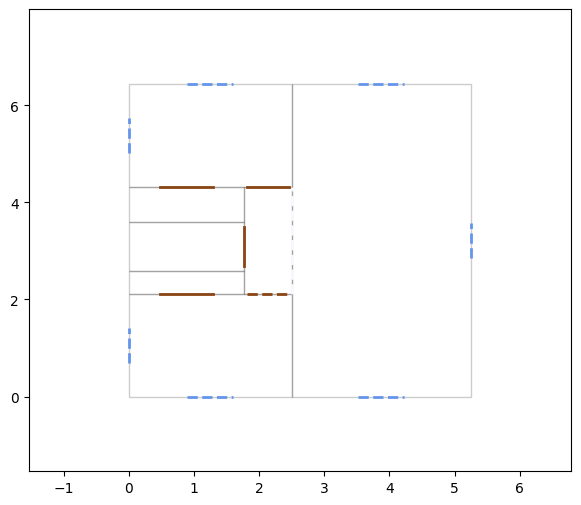

In [34]:
time = datetime(2017, 7, 1, 8, 15)
fig, ax = plt.subplots(nrows=1, figsize=(7, 6))
ax = plot_zone_domains(case.idf, ax)
ax, data = plot_surfaces(case, time, ax)